In [1]:
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery, Document


from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.types import Send, Command

from langchain_core.messages import AIMessage, ToolMessage

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional, Sequence
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import inspect
import instructor
import json

from utils.utils import get_tool_descriptions, format_ai_message

/Users/tanyakanodia/learning-ai/00-ai-engineering-bootcamp-cohort-2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    question_relevant: bool = False
    initial_query: str = ""
    answer: str = ""
    query: str = ""
    k: int = 10

In [3]:
class QueryExpandResponse(BaseModel):
    expanded_query: List[str]

In [4]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def query_expand_node(state: State):

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

    Instructions:
    - You will be given a question and you need to expand it into a list statements that can be used in contextual search to retrieve relevant products.
    - The statements should not overlap in context. Single item should not be expanded into multiple statements unless it is specifically mentioned in several contexts.

    <Question>
    {{ query }}
    </Question>
    """

   template = Template(prompt_template)
   
   prompt = template.render(
      query=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "expanded_query": response.expanded_query
      }




In [5]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )

    return response.data[0].embedding


In [6]:
def query_expand_conditional_edges(state: State):

    send_messages = []

    for query in state.expanded_query:
        send_messages.append(
            Send(
                "retrieve_node",
                {
                    "query": query,
                    "k": 10
                }
            )
        )

    return send_messages

In [18]:
@traceable(
    name="retrieve_top_n",
    run_type="retriever"
)
def retrieve_node(state: State) -> dict:

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(state["query"])

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=state["query"],
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=state["k"],
    )

    retrieved_context = []
    retrieved_context_ids = [] 
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return {
        "retrieved_context": [formatted_context],
    }

In [19]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question.")

In [20]:


@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def aggregator_node(state: State) -> dict:

   preprocessed_context = "\n".join(state.retrieved_context)

   prompt_template =  """You are a shopping assistant that can answer questions about the products in stock.

    You will be given a question and a list of context.

    Instructions:
    - You need to answer the question based on the provided context only.
    - Never use word context and refer to it as the available products.
    - The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

    Context:
    {{ preprocessed_context }}

    Question:
    {{ question }}
    """

   template = Template(prompt_template)
   
   prompt = template.render(
      preprocessed_context=preprocessed_context,
      question=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AggregatorResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "answer": response.answer
   }

### User intent router node

In [21]:
class IntentRouterResponse(BaseModel):
    question_relevant: bool
    answer: str

In [22]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def intent_router_node(state: State):

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

    Instructions:
    - You will be given a question and you need to clasify it into relevant or not relevant.
    - If the question is not relevant, return False in field "question_relevant" and set "answer" to explanation why it is not relevant.
    - If the question is relevant, return True in field "question_relevant" and set "answer" to "".
    - You should only answer questions about the products in stock. If the question is not about the products in stock, you should ask for clarification.

    <Question>
    {{ query }}
    </Question>
    """

   template = Template(prompt_template)
   
   prompt = template.render(
      query=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=IntentRouterResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "question_relevant": response.question_relevant,
      "answer": response.answer
      }

In [23]:
def intent_router_conditional_edges(state: State):

    if state.question_relevant:
        return "query_expand_node"
    else:
        return "end"

In [24]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)
workflow.add_node("intent_router_node", intent_router_node)

workflow.add_edge(START, "intent_router_node")

# this conditional edge does not have a end node - as the function decides where to send the message next
workflow.add_conditional_edges("query_expand_node", query_expand_conditional_edges)
workflow.add_conditional_edges(
    "intent_router_node",
    intent_router_conditional_edges,
    {
        "query_expand_node": "query_expand_node",
        "end": END
    }
)

workflow.add_edge("retrieve_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

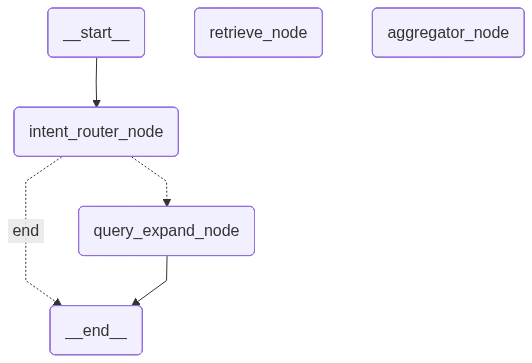

In [14]:
display(Image(graph.get_graph().draw_mermaid_png()))


In [15]:
initial_state = {
    "initial_query": "Whats the weather today?"
}
result = graph.invoke(initial_state)

In [16]:
result


{'retrieved_context': [],
 'question_relevant': False,
 'initial_query': 'Whats the weather today?',
 'answer': 'The question is not relevant because it is about the weather, which is unrelated to the products in stock.'}

In [25]:
initial_state = {
    "initial_query": "Can I get some cool lights and a waterproof speaker for our party next week?"
}
result = graph.invoke(initial_state)

Fetching 18 files: 100%|██████████| 18/18 [00:00<00:00, 268674.28it/s]


In [26]:
print(result["answer"])

Yes, you can get a cool lights and waterproof Bluetooth speaker for your party. Here are two excellent options from the available products:

1. Dazzling Boom Bluetooth Speaker:
- Power: 60W (80W Peak) with 2*30W full-range speakers
- Sound: Room-filling loud stereo sound with crisp highs, detailed mids, and punchy bass
- Lights: Dynamic beat-driven colorful lights that sync to the music with 3 lighting modes and 2 side lights for better visual experience
- Waterproof: IPX7 waterproof, can be submerged up to 3.3 feet for 30 minutes and floats on water
- Battery: Rechargeable battery with power bank function
- Connectivity: Bluetooth 5.0, up to 100ft wireless range, can sync up to 100 speakers for immersive sound
- Additional: Built-in microphone for hands-free calls, LCD screen for battery and volume status, AUX-IN jack
- Portability: Compact design with ergonomic carrying handle

2. ZEALOT Bluetooth Speaker S57:
- Power: 80W with 2 woofers, two 25W full-range drivers, and two 15W tweet

In [27]:
initial_state = {
    "initial_query": "Can I get news about Delhi and Mumbai and what is the best speaker in the marker?"
}
result = graph.invoke(initial_state)

In [28]:
print(result["answer"])

The question asks for news about Delhi and Mumbai, which is not related to the products in stock. It also asks about the best speaker in the market, which is too general and not specific to the products available in stock. Please ask about specific products in stock for assistance.


In [29]:
initial_state = {
    "initial_query": "Can I get news about Delhi and Mumbai and help me buy a speaker for a party?"
}
result = graph.invoke(initial_state)

In [30]:
print(result["answer"])

The question is not relevant because it asks for news about Delhi and Mumbai, which is not related to the products in stock. It also asks for help buying a speaker for a party, but it is not clear which specific products or product categories are in stock. Please ask specifically about the products available in stock.


TODO: Consider how to handle situations where only part of the query is relevant and part is not. 
Perhaps add another processing layer to break the query into parts and handle each separately.
Think about a design or approach for implementing this functionality.